
The SEM dataset is composed of a training and a validation images acquired on a scanning 
electron microscopy (SEM). They were originally used in Buchholtz et al (2019) to showcase
CARE denoising. Here, we demonstrate the performances of Noise2Void on this particular dataset!

In [9]:
# Imports necessary to execute the code
from pathlib import Path

import matplotlib.pyplot as plt
import tifffile
from careamics import CAREamist
from careamics.config import create_n2n_configuration
from careamics_portfolio import PortfolioManager

## Import the dataset

The dataset can be directly downloaded using the `careamics-portfolio` package, which
uses `pooch` to download the data.

The N2N SEM dataset consists of EM images with 7 different levels of noise:

- Image 0 is recorded with 0.2 us scan time
- Image 1 is recorded with 0.5 us scan time
- Image 2 is recorded with 1 us scan time
- Image 3 is recorded with 1 us scan time
- Image 4 is recorded with 2.1 us scan time
- Image 5 is recorded with 5.0 us scan time
- Image 6 is recorded with 5.0 us scan time and is the avg. of 4 images


In [2]:
# instantiate data portfolio manage
portfolio = PortfolioManager()

# and download the data
root_path = Path("./data")
files = portfolio.denoising.N2V_SEM.download(root_path)

100%|████████████████████████████████████████| 173M/173M [00:00<00:00, 182GB/s]
Unzipping contents of '/Users/joran.deschamps/git/careamics/careamics-examples/applications/n2n/data/denoising-N2N_SEM' to '/Users/joran.deschamps/git/careamics/careamics-examples/applications/n2n/data/denoising-N2N_SEM.unzip'


## Visualize data

Text(0.5, 1.0, 'Target Image')

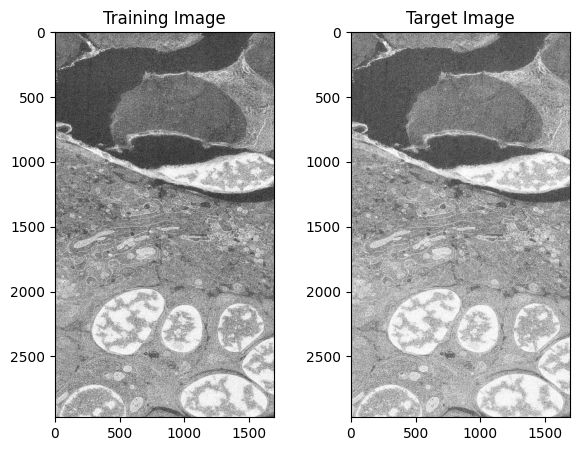

In [8]:
# load training and validation image and show them side by side
train_stack = tifffile.imread(files[1])
test_stack = tifffile.imread(files[2])

# use the 1 us scan time to perform Noise2Noise
train_image = train_stack[2]
train_target = train_stack[3]


fig, ax = plt.subplots(1, 2, figsize=(7, 5))
ax[0].imshow(train_image, cmap="gray")
ax[0].set_title("Training Image")
ax[1].imshow(train_target, cmap="gray")
ax[1].set_title("Target Image")

## Train with CAREamics

The easiest way to use CAREamics is to create a configuration and a `CAREamist`. 

### Create configuration

The configuration can be built from scratch, giving the user full control over the various
parameters available in CAREamics. However, a straightforward way to create a configuration
for a particular algorithm is to use one of the convenience functions.

In [10]:
config = create_n2n_configuration(
    experiment_name="sem_n2n",
    data_type="array",
    axes="YX",
    patch_size=(64, 64),
    batch_size=64,
    num_epochs=30,
)

print(config)

{'algorithm_config': {'algorithm': 'n2n',
                      'loss': 'mae',
                      'lr_scheduler': {'name': 'ReduceLROnPlateau',
                                       'parameters': {}},
                      'model': {'architecture': 'UNet',
                                'conv_dims': 2,
                                'depth': 2,
                                'final_activation': 'None',
                                'in_channels': 1,
                                'independent_channels': False,
                                'n2v2': False,
                                'num_channels_init': 32,
                                'num_classes': 1},
                      'optimizer': {'name': 'Adam',
                                    'parameters': {'lr': 0.0001}}},
 'data_config': {'axes': 'YX',
                 'batch_size': 64,
                 'data_type': 'array',
                 'patch_size': [64, 64],
                 'transforms': [{'mean': 0.485,
     

### Train

A `CAREamist` can be created using a configuration alone, and then be trained by using
the data already loaded in memory.

In [ ]:
# instantiate a CAREamist
careamist = CAREamist(source=config)

# train
careamist.train(
    train_source=train_image,
    train_target=train_target,
    val_minimum_split=5,
)

## Predict with CAREamics

Prediction is done with the same `CAREamist` used for training. Because the image is large
we predict using tiling.

In [ ]:
prediction = careamist.predict(source=train_image, tile_size=(256, 256))

### Visualize the prediction

In [ ]:
# Show the full image and crops
x_start, x_end = 600, 850
y_start, y_end = 200, 450

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].imshow(train_image, cmap="gray")
ax[0, 1].imshow(prediction.squeeze(), cmap="gray")
ax[1, 0].imshow(train_image[y_start:y_end, x_start:x_end], cmap="gray")
ax[1, 1].imshow(prediction.squeeze()[y_start:y_end, x_start:x_end], cmap="gray")